In [2]:
# 파이썬≥3.5 필수
import sys
assert sys.version_info >= (3, 5)
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
# 깔끔한 그래프 출력을 위해 %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
from matplotlib import font_manager, rc
import platform
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False
# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3
# 그래픽 출력을 조금 더 고급화하기 위한 라이브러리
import seaborn as sns

#과학 기술 통계 라이브러리
import scipy as sp
from scipy import stats
# 사이킷런 ≥0.20 필수 : 0.20에서 데이터 변환을 위한 Transformer클래스가 추가됨
import sklearn
assert sklearn.__version__ >= "0.20"

# 데이터를 분할할 때 동일한 분할을 만들기 위해서
# 모델을 만드는 작업을 여러 번에 걸쳐서 하는 경우 시드가 변경이 되서 훈련용 데이터가
# 자주 변경이 되면 결국 모든 데이터를 가지고 모델을 생성하는 결과
# Overfit이 될 가능성이 높아짐
np.random.seed(42)

import pandas as pd


## 데이터 가져오기


In [3]:
bike_df = pd.read_csv('./data/data/data/bike/train.csv')
print(bike_df.shape)
bike_df.head(3)


(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


## 전처리

In [4]:
# datetime을 날짜 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [5]:
# 날짜를 년 월 일 시간으로 본할
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [7]:
# 불 필요한 컬럼 제거
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)


KeyError: "['datetime', 'casual', 'registered'] not found in axis"

In [8]:
bike_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


In [11]:
# downcasting 함수
def downcast(df):
    start_mem = df.memory_usage().sum() / 1024

    for col in df.columns :
        dtype_name = df[col].dtype.name
        if dtype_name == 'object' :
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else :
            df[col] = pd.to_numeric(df[col], downcast = 'float')

    end_mem = df.memory_usage().sum() / 1024
    print(100 * (start_mem - end_mem) / start_mem, " % 압축됨")
    return df

bike_df = downcast(bike_df)
bike_df.info()

76.91438099679229  % 압축됨
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int8   
 1   holiday     10886 non-null  int8   
 2   workingday  10886 non-null  int8   
 3   weather     10886 non-null  int8   
 4   temp        10886 non-null  float32
 5   atemp       10886 non-null  float32
 6   humidity    10886 non-null  int8   
 7   windspeed   10886 non-null  float32
 8   count       10886 non-null  int16  
 9   year        10886 non-null  int16  
 10  month       10886 non-null  int8   
 11  day         10886 non-null  int8   
 12  hour        10886 non-null  int8   
dtypes: float32(3), int16(2), int8(8)
memory usage: 255.3 KB


In [12]:
# 메모리 정리
import gc
gc.collect()

810

In [13]:
# 평가 지표를 위한 함수
from sklearn.metrics import mean_squared_error, mean_absolute_error

# rmsle 를 구해주는 함수
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))





## 단순 선형 회귀 수행

In [15]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, 
random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.899, MAE: 105.925


C:\Users\USER\AppData\Local\Temp\ipykernel_14280\2183169230.py:7: RuntimeWarning: invalid value encountered in log1p
  log_pred = np.log1p(pred)


In [16]:
# 오차가 큰 값 확인
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
get_top_error_data(y_test,pred,n_tops=5)


      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


## 타겟에 로그 변환 후 모델을 다시 훈련

<Axes: >

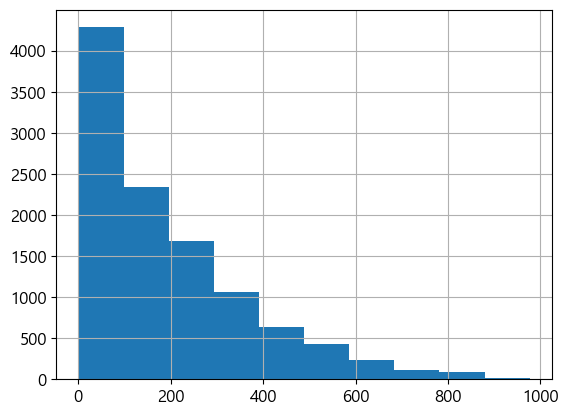

In [17]:
# 분포 확인
y_target.hist()


<Axes: >

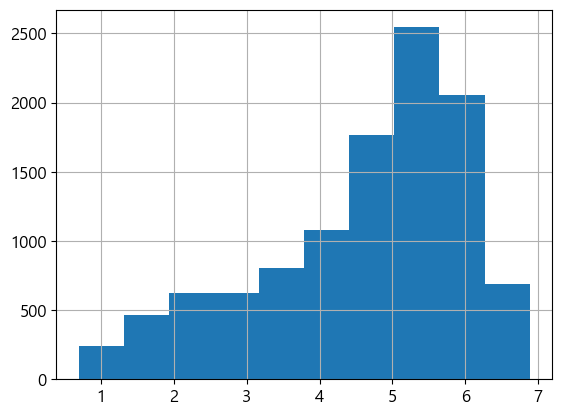

In [18]:
# 타겟의 로그 변환
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [19]:
y_target_log = np.log1p(y_target)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=42)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

pred = lr_reg.predict(X_test)

# 로그 변환 한 값을 원래의 값으로 되돌려야 함
# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)
# 예측 값 역시 Log 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)
evaluate_regr(y_test_exp ,pred_exp)




RMSLE: 1.020, RMSE: 160.729, MAE: 108.235


### 피처를 원 핫 인코딩 한 후 수행

<Axes: >

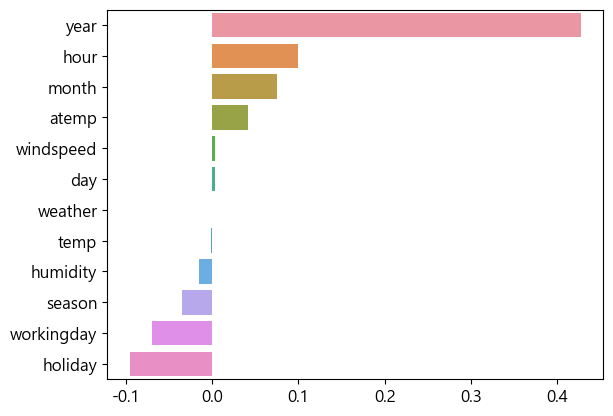

In [20]:
# 회귀 계수를 확인
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)

sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [21]:
# 원 핫 인코딩
X_feature_ohe = pd.get_dummies(X_features, columns=['year','month','day','hour','holiday','workingday','season','weather'])
X_feature_ohe.head()

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0


In [23]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_feature_ohe, y_target_log, test_size=0.3, random_state=42)


In [28]:
# 모델과 데이터를 받아서 훈련하고 평가 지표를 출력하는 함수
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print(model.__class__.__name__)
    evaluate_regr(y_test, pred)



In [31]:
# 선형 회귀 모델 수행
lr_reg = LinearRegression()
get_model_predict(lr_reg,X_train, X_test, y_train, y_test,is_expm1=True)

LinearRegression
RMSLE: 0.587, RMSE: 98.023, MAE: 63.486


### 규제 모델을 이용한 훈련

In [36]:
# 규제 모델을 사용하면 선형 회귀보다는 성능이 좋아질 가능성이 높음
from sklearn.linear_model import Ridge, Lasso
ridge_reg = Ridge(alpha = 10)
lasso_reg = Lasso(alpha = 0.001)

get_model_predict(ridge_reg, X_train, X_test, y_train, y_test, is_expm1=True)
get_model_predict(lasso_reg, X_train, X_test, y_train, y_test, is_expm1=True)

Ridge
RMSLE: 0.587, RMSE: 96.827, MAE: 62.889
Lasso
RMSLE: 0.586, RMSE: 96.683, MAE: 62.522


### 트리 모델 적용

In [38]:
# 트리 모델 적용
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


# 랜덤 포레스트, GBM, XGBoost 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)


for model in [rf_reg, gbm_reg, xgb_reg]:
# XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)


RandomForestRegressor
RMSLE: 0.349, RMSE: 48.045, MAE: 30.050
GradientBoostingRegressor
RMSLE: 0.331, RMSE: 51.707, MAE: 32.193
XGBRegressor
RMSLE: 0.344, RMSE: 50.529, MAE: 31.145


### 군집

### 샘플 데이터를 이용한 군집

In [39]:
# 샘플 데이터 생성
from sklearn.datasets import make_blobs
# 200개의 데이터를 생성하고 피처는 2개
# 중심은 3개 표준편차는 0.8을 사용
X,y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.8,random_state=42)
print(X.shape, y.shape)


(200, 2) (200,)


In [40]:
# y값과 분포 확인
unique, counts = np.unique(y, return_counts=True)
print(unique)
print(counts)


[0 1 2]
[67 67 66]


In [41]:
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
clusterDF.head(3)

,ftr1,ftr2,target
0,6.132498,2.352236,1
1,-4.604994,9.671808,0
2,-6.889425,-7.597913,2


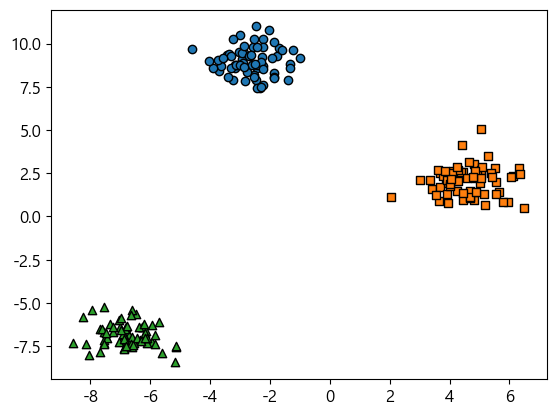

In [42]:
# 데이터 분포 확인
target_list = np.unique(y)

# 마커의 모양
markers=['o', 's', '^', 'P','D','H','x']

for target in target_list:
    target_cluster = clusterDF[clusterDF['target']==target]
    plt.scatter(x=target_cluster['ftr1'], y=target_cluster['ftr2'], edgecolor='k', 
    marker=markers[target] )
plt.show()


In [44]:
from sklearn.mixture import GaussianMixture
# 3개의 집단으로 군집
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
print(y_pred)
print(y)

[2 0 1 1 1 1 0 1 2 1 2 2 2 2 2 1 0 1 2 1 2 2 1 0 1 0 0 1 0 2 2 2 1 1 0 0 1
 0 1 0 2 0 1 2 1 2 2 1 2 0 1 0 1 0 0 0 1 2 0 2 1 0 1 1 1 1 0 0 1 0 0 1 0 2
 0 2 2 0 2 0 0 2 2 1 1 1 1 0 2 1 2 0 0 0 2 1 0 2 2 0 1 1 0 1 0 2 1 2 2 1 2
 2 0 1 0 1 1 0 0 0 1 2 0 1 1 2 0 0 2 0 2 1 0 1 1 2 2 2 0 2 0 0 1 2 2 0 2 1
 1 2 0 1 2 1 2 1 1 0 2 2 0 2 2 1 0 2 2 0 1 2 1 0 2 1 0 2 0 0 0 2 0 2 1 1 1
 0 2 2 2 0 0 2 1 1 0 1 0 0 2 2]
[1 0 2 2 2 2 0 2 1 2 1 1 1 1 1 2 0 2 1 2 1 1 2 0 2 0 0 2 0 1 1 1 2 2 0 0 2
 0 2 0 1 0 2 1 2 1 1 2 1 0 2 0 2 0 0 0 2 1 0 1 2 0 2 2 2 2 0 0 2 0 0 2 0 1
 0 1 1 0 1 0 0 1 1 2 2 2 2 0 1 2 1 0 0 0 1 2 0 1 1 0 2 2 0 2 0 1 2 1 1 2 1
 1 0 2 0 2 2 0 0 0 2 1 0 2 2 1 0 0 1 0 1 2 0 2 2 1 1 1 0 1 0 0 2 1 1 0 1 2
 2 1 0 2 1 2 1 2 2 0 1 1 0 1 1 2 0 1 1 0 2 1 2 0 1 2 0 1 0 0 0 1 0 1 2 2 2
 0 1 1 1 0 0 1 2 2 0 2 0 0 1 1]


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [ ]:
# 매핑된 결과 확인
from scipy import stats
mapping={}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y == class_id])
    mapping[mode[0]] = class_id
print(mapping)


### 과일 이미지를 이용한 군집

In [46]:
fruits = np.load('./data/data/data/fruits_300.npy')
print(fruits.shape)
# 첫 번째 이미지 데이터 확인 - 흑백 이미지
print(fruits[0, 0, :])

(300, 100, 100)
[  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   2   1
   2   2   2   2   2   2   1   1   1   1   1   1   1   1   2   3   2   1
   2   1   1   1   1   2   1   3   2   1   3   1   4   1   2   5   5   5
  19 148 192 117  28   1   1   2   1   4   1   1   3   1   1   1   1   1
   2   2   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1]


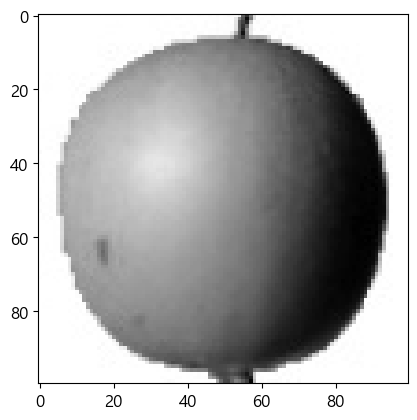

In [49]:
# 이미지 출력 - 반전해서 출력
# 우리가 관심을 갖는 것은 물체이므로 물체 이외의 부분은 흰색으로 보여지는 것이
# 더 나은 경우가 있음
plt.imshow(fruits[0], cmap='gray_r')
plt.show()

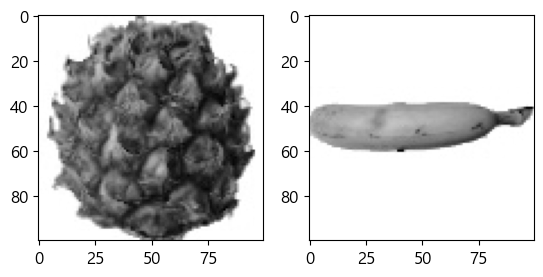

In [50]:
# 파인애플과 바나나 출력
fig, axs = plt.subplots(1, 2)
axs[0].imshow(fruits[100], cmap='gray_r')
axs[1].imshow(fruits[200], cmap='gray_r')
plt.show()

In [54]:
# 이미지 데이터를 비교하기 위해서 1차원으로 변경
# print(fruits[0].reshape(-1, 100*100))
# print(fruits[0].flatten()) 위와 같은 결과 나옴

apple = apple = fruits[0:100].reshape(-1, 100*100)
pineapple = fruits[100:200].reshape(-1, 100*100)
banana = fruits[200:300].reshape(-1, 100*100)
print(apple.shape)

(100, 10000)


In [56]:
# 과일의 평균 확인
print(apple.mean(axis=1))
print(pineapple.mean(axis=1))
print(banana.mean(axis=1))

# 바나나의 평균이 낮은편임 -> 빈 영역이 많기 때문

[ 88.335  97.925  87.371  98.37   92.871  82.644  94.424  95.6    90.681
  81.623  87.058  95.075  93.842  87.017  97.508  87.202  88.983 100.916
  92.782 100.918 104.985  88.674  99.564  97.249  94.118  92.194  95.167
  93.332 102.897  94.669  90.528  89.074  97.764  97.294 100.756  90.524
 100.254  85.845  96.462  97.149  90.711 102.319  87.163  89.875  86.733
  86.399  95.287  89.171  96.816  91.66   96.106  99.683  94.972  87.481
  89.26   89.527  93.799  97.398  87.151  97.825 103.22   94.424  83.666
  83.516 102.845  87.038  91.274 100.485  93.839  90.857  97.462  97.502
  82.446  87.179  96.921  90.314  90.565  97.654  98.092  93.625  87.387
  84.707  89.114  86.765  88.73   86.643  96.732  97.26   81.942  87.169
  97.207  83.471  95.978  91.81   98.409 100.782 101.556 100.703  91.61
  88.898]
[ 99.324  87.162  97.193  97.469  98.889  97.882  95.144  92.946  95.841
  96.949  93.286 101.277  91.651  98.39   84.328 100.702  99.023  87.53
  99.411  91.857  90.388  99.507  95.85   9

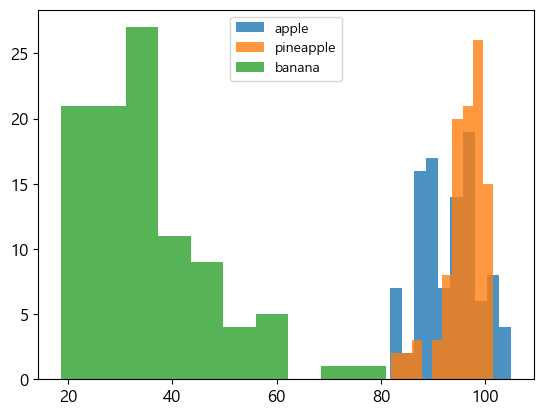

In [57]:
# 과일 별 평균 분포 확인
plt.hist(np.mean(apple, axis=1), alpha=0.8)
plt.hist(np.mean(pineapple, axis=1), alpha=0.8)
plt.hist(np.mean(banana, axis=1), alpha=0.8)
plt.legend(['apple', 'pineapple', 'banana'])
plt.show()

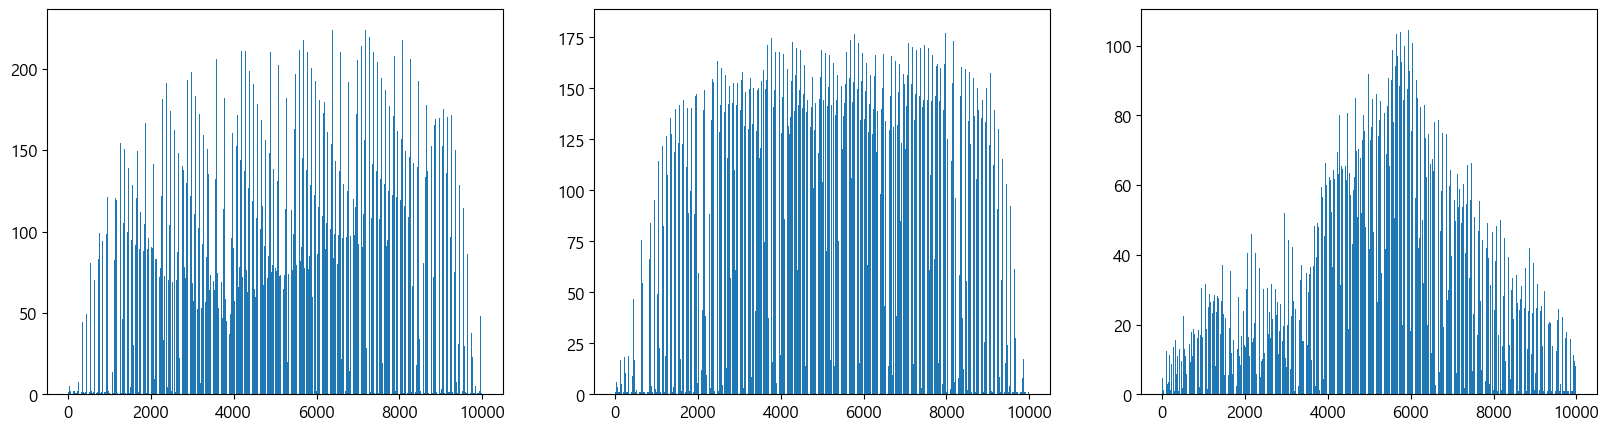

In [58]:
# 픽셀별 평균을 확인
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].bar(range(10000), np.mean(apple, axis=0))
axs[1].bar(range(10000), np.mean(pineapple, axis=0))
axs[2].bar(range(10000), np.mean(banana, axis=0))
plt.show()

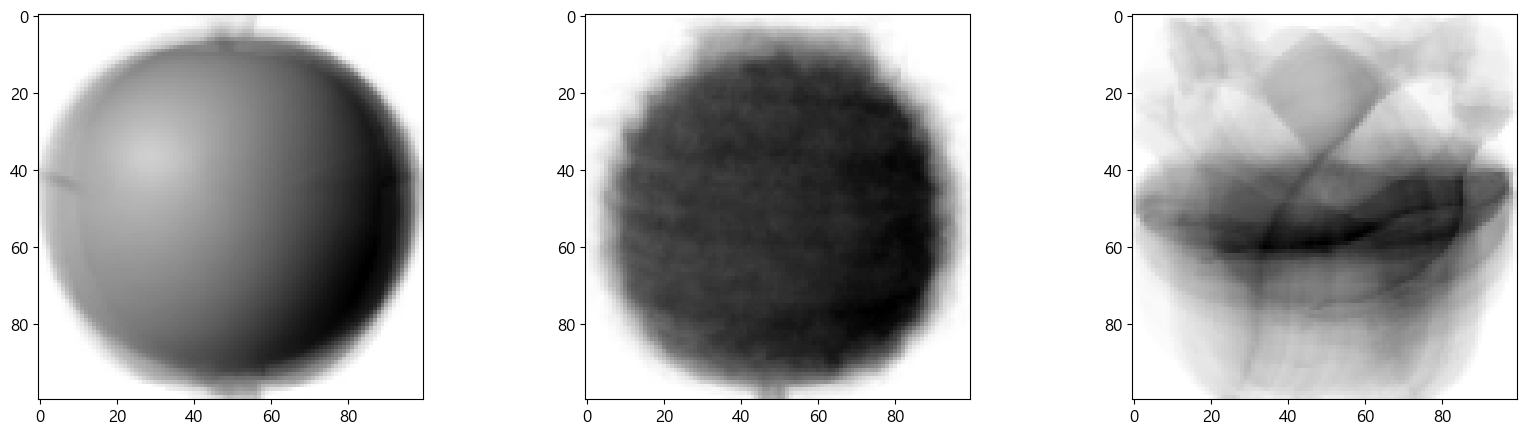

In [60]:
# 평균을 가지고 이미지를 생성
apple_mean = np.mean(apple, axis=0).reshape(100, 100)
pineapple_mean = np.mean(pineapple, axis=0).reshape(100, 100)
banana_mean = np.mean(banana, axis=0).reshape(100, 100)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(apple_mean, cmap='gray_r')
axs[1].imshow(pineapple_mean, cmap='gray_r')
axs[2].imshow(banana_mean, cmap='gray_r')
plt.show()


In [61]:
# 모든 데이터에서 사과의 평균을 뺀 절대값 구하기
abs_diff = np.abs(fruits - apple_mean)
abs_mean = np.mean(abs_diff, axis=(1,2))
print(abs_mean.shape)

(300,)


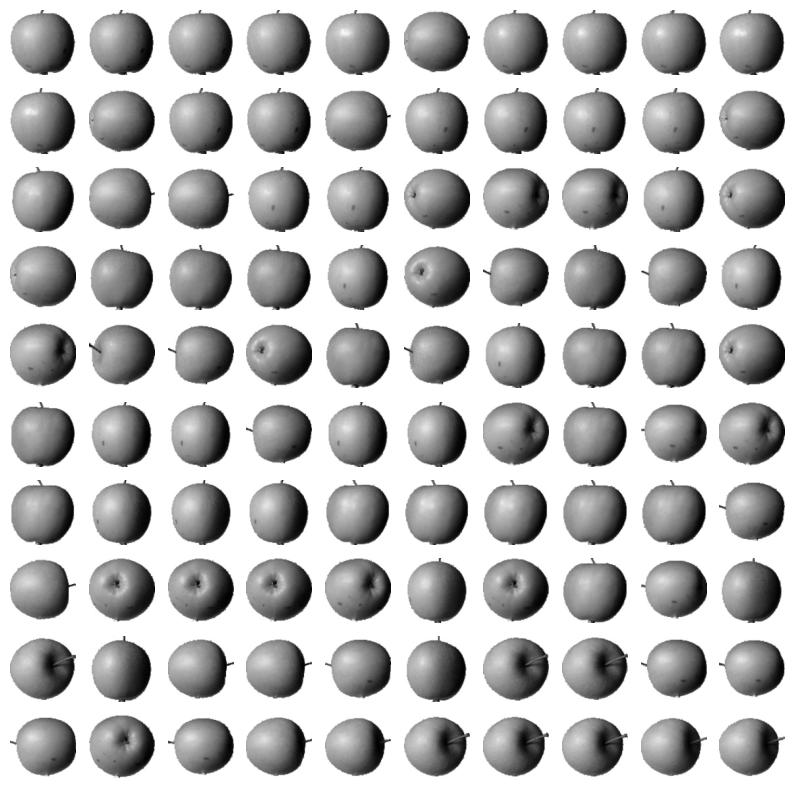

In [63]:
# 평균을 뺀 절대값이 가장 작은 것 100개 출력
apple_index = np.argsort(abs_mean)[:100]
fig, axs = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        axs[i, j].imshow(fruits[apple_index[i*10 + j]], cmap='gray_r')
        axs[i, j].axis('off')
plt.show()

## K-Means 알고리즘

### 임의의 샘플 데이터를 이용한 군집

In [64]:
from sklearn.datasets import make_blobs

# 중심점의 좌표와 표준 편차 생성
blob_centers = np.array(
[[ 0.2, 2.3],
[-1.5 , 2.3],
[-2.8, 1.8],
[-2.8, 2.8],
[-2.8, 1.3]])

blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
cluster_std=blob_std, random_state=42)

그림 저장: blobs_plot


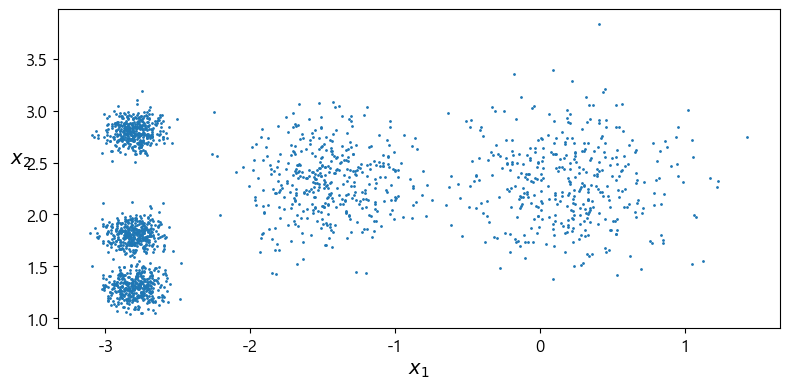

In [65]:
# 데이터 확인
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

In [66]:
# 군집 수행
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)
print(y_pred)

c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


[2 1 3 ... 1 2 4]


In [67]:
# 각 그룹의 중앙점의 좌표 출력
print(kmeans.cluster_centers_)

[[-2.792  1.297]
 [ 0.209  2.304]
 [-2.798  2.8  ]
 [-1.445  2.321]
 [-2.804  1.809]]


In [68]:
# 예측
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)


array([1, 1, 2, 2])

C:\Users\USER\AppData\Local\Temp\ipykernel_14280\1708286054.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),


그림 저장: voronoi_plot


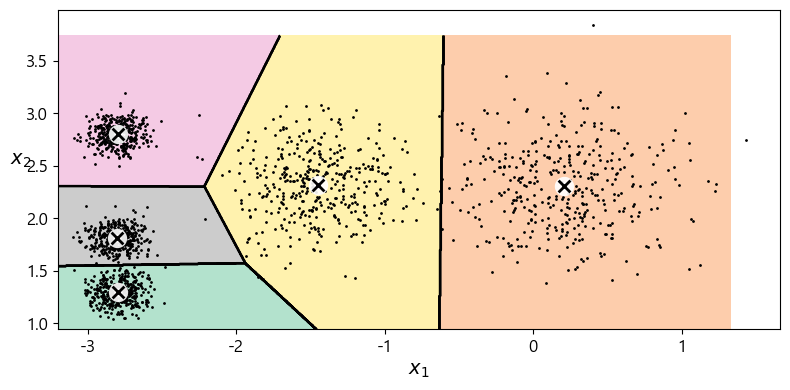

In [77]:
# 결정 경계 시각화 - voronoi diagram()
# voronoi diagram: 평면을 특정 점까지의 거리가 가까운 점의 집합으로 분할한 그림

# 데이터의 분포를 시각화함
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12, 
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) - 0.1

    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap='Pastel2')
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidth=1, colors='k')
    plot_data(X)
    
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig('voronoi_plot')
plt.show()
    


In [80]:
# 중심 점과의 거리 확인 - 유클리드 거리
print(kmeans.transform(X_new))
print(kmeans.predict(X_new))

[[2.879 0.369 2.911 1.48  2.81 ]
 [5.835 2.807 5.853 4.457 5.807]
 [1.715 3.284 0.284 1.697 1.207]
 [1.22  3.215 0.361 1.565 0.719]]
[1 1 2 2]


In [81]:
# 유클리드 거리 확인
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)
# 위에서 계산한 값과 같은 값이 나옴

array([[2.879, 0.369, 2.911, 1.48 , 2.81 ],
       [5.835, 2.807, 5.853, 4.457, 5.807],
       [1.715, 3.284, 0.284, 1.697, 1.207],
       [1.22 , 3.215, 0.361, 1.565, 0.719]])

In [82]:
# 평가 지표 출력
print(kmeans.inertia_)
print(kmeans.score(X))


213.42177131258907
-213.4217713125891


In [84]:
%%time
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


CPU times: total: 2.83 s
Wall time: 347 ms


In [85]:
%%time
from sklearn.cluster import MiniBatchKMeans
k = 5
miniBatchMeans = MiniBatchKMeans(n_clusters=k, random_state=42)
y_pred = miniBatchMeans.fit_predict(X)
print(miniBatchMeans.inertia_)

213.57214964975
CPU times: total: 1.12 s
Wall time: 143 ms


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2560 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [87]:
# 이너셔를 이용한 최적의 클러스터 개수 찾기
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]
print(inertias)

c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment v

[3535.902973409425, 1169.722330993897, 662.9432340781606, 265.87402716855036, 213.42177131258916, 173.41021888733098, 146.70624728469897, 122.21669990809282, 107.07177911806437]


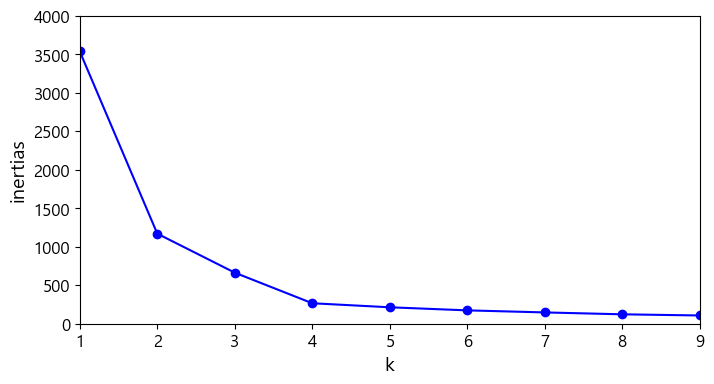

In [88]:
# elbow를 찾기 위해서 시각화
plt.figure(figsize=(8,4))
plt.plot(range(1,10), inertias, "bo-")
plt.xlabel("k", fontsize=14)
plt.ylabel("inertias", fontsize=14)
plt.axis([1,9,0,4000])
plt.show()

In [89]:
from sklearn.metrics import silhouette_score
print(silhouette_score(X, kmeans.labels_))

0.656578194104489


[0.5888699625637426, 0.5690585495403864, 0.6848978374857873, 0.656578194104489, 0.6038071457653064, 0.5564756994071687, 0.5607889470176775, 0.5635438960242384]


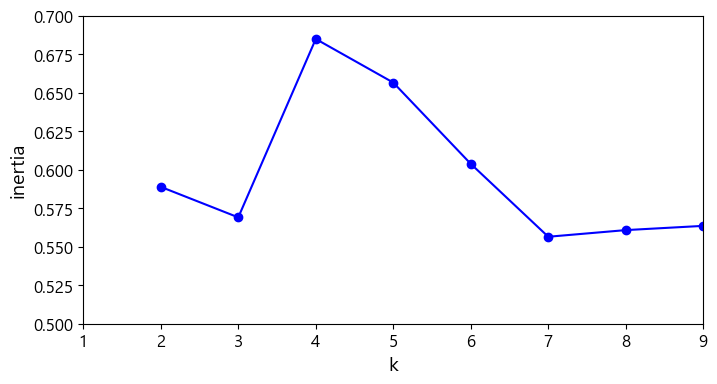

In [98]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]
print(silhouette_scores)

# elbow를 찾기 위해서 시각화
plt.figure(figsize=(8,4))
plt.plot(range(2,10), silhouette_scores, "bo-")
plt.xlabel("k", fontsize=14)
plt.ylabel("inertia", fontsize=14)
plt.axis([1,9,0.5,0.7])
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_14280\1425865281.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis')
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[[-1.021e+00  1.055e-01]
 [ 9.058e-01  4.579e-01]
 [ 6.184e-01  7.571e-01]
 [ 1.228e+00 -4.252e-01]
 [ 3.294e-01 -2.069e-01]
 [ 1.814e-01  1.114e-01]
 [-6.241e-01  8.184e-01]
 [ 1.581e+00 -2.496e-01]
 [ 1.787e+00 -1.690e-01]
 [ 1.428e-01  9.715e-01]
 [-4.675e-01  8.049e-01]
 [ 1.885e+00 -5.941e-02]
 [ 1.503e+00 -3.895e-01]
 [-8.055e-01  5.739e-01]
 [ 1.898e+00  1.269e-01]
 [ 1.818e+00 -1.165e-01]
 [-1.366e-01  1.106e+00]
 [ 1.063e+00 -5.071e-01]
 [-9.300e-01  5.732e-01]
 [-4.890e-01  7.892e-01]
 [ 3.071e-01 -1.292e-01]
 [ 8.852e-01  5.286e-01]
 [ 9.612e-01 -5.597e-01]
 [-9.295e-01  2.555e-01]
 [-4.355e-01  8.337e-01]
 [-3.646e-01  8.885e-01]
 [-8.503e-01  5.216e-01]
 [-5.060e-01  8.968e-01]
 [ 2.551e-01 -2.054e-01]
 [ 4.043e-01 -3.883e-01]
 [ 1.003e+00  2.698e-01]
 [ 9.017e-01  5.675e-01]
 [-3.693e-02  9.895e-01]
 [-7.941e-01  6.884e-01]
 [ 9.677e-01 -4.510e-01]
 [ 1.014e-02  3.665e-01]
 [ 5.497e-01 -3.590e-01]
 [ 5.910e-01 -3.835e-01]
 [ 1.496e+00 -4.131e-01]
 [-7.916e-01  6.411e-01]


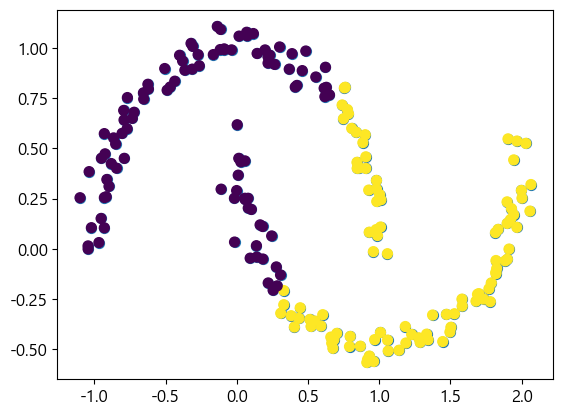

In [105]:
## k-means 의 한계
# 완전한 원형이 아닌 데이터 생성

from sklearn.datasets import make_moons
X, y = make_moons(200, noise=0.05, random_state=42)
plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis')

labels = KMeans(2, random_state=42).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,s=50, cmap='viridis')



(533, 800, 3)
[[[0.098 0.114 0.008]
  [0.094 0.11  0.004]
  [0.094 0.114 0.   ]
  ...
  [0.224 0.412 0.082]
  [0.22  0.404 0.086]
  [0.204 0.388 0.075]]

 [[0.094 0.11  0.004]
  [0.09  0.106 0.   ]
  [0.09  0.106 0.   ]
  ...
  [0.235 0.424 0.086]
  [0.231 0.416 0.098]
  [0.216 0.4   0.086]]

 [[0.09  0.106 0.008]
  [0.086 0.102 0.004]
  [0.086 0.102 0.   ]
  ...
  [0.259 0.447 0.11 ]
  [0.247 0.435 0.106]
  [0.227 0.412 0.094]]

 ...

 [[0.055 0.071 0.004]
  [0.055 0.071 0.004]
  [0.051 0.078 0.008]
  ...
  [0.051 0.239 0.012]
  [0.035 0.22  0.008]
  [0.02  0.2   0.008]]

 [[0.055 0.071 0.004]
  [0.055 0.071 0.004]
  [0.047 0.075 0.004]
  ...
  [0.043 0.231 0.004]
  [0.027 0.212 0.   ]
  [0.012 0.192 0.   ]]

 [[0.051 0.067 0.   ]
  [0.051 0.067 0.   ]
  [0.043 0.071 0.   ]
  ...
  [0.039 0.227 0.   ]
  [0.02  0.204 0.   ]
  [0.008 0.188 0.   ]]]


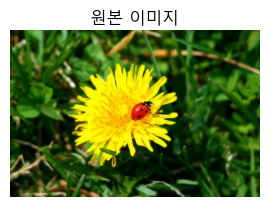

In [107]:
# 군집을 이용한 이미지 분할
# 이미지를 읽어와서 출력하기
from matplotlib.image import imread
image = imread('./data/data/data/ladybug.png')
print(image.shape)

plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.subplot(231)
plt.imshow(image)
plt.title("원본 이미지")
plt.axis('off')

# print(image) # 0.0~1.0 사이의 값으로 되어있음

c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_k

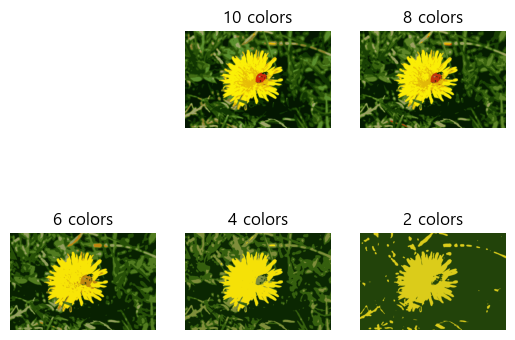

In [111]:
# 색상을 가지고 군집을 수행
# 색상 압축
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
# 각 픽셀이 속한 클러스터의 중앙 좌표를 저장
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)
#print(segmented_img)

segmented_imgs = []
n_colors = [10, 8, 6, 4, 2]
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

for idx, n_clusters in enumerate(n_colors) :
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')
plt.show()



In [112]:
# 군집을 이용한 차원 축소 후 분류
# 8 * 8 크기의 흑백 이미지 1797개 가져오기

from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

print(X_digits.shape)
print(y_digits.shape)

(1797, 64)
(1797,)


In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

log_reg_score = log_reg.score(X_test, y_test)
print(log_reg_score)

0.9688888888888889


In [115]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
("kmeans", KMeans(n_clusters=50, random_state=42)),
("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", 
max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


0.978

In [118]:
# 최적의 클러스터 개수 찾기
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)
print(grid_xlf.best_params_)
print(grid_clf.score(X_test, y_test))

Fitting 3 folds for each of 98 candidates, totalling 294 fits


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=2; total time=   0.3s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=2; total time=   0.3s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=2; total time=   0.3s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=3; total time=   0.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=3; total time=   0.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=3; total time=   0.3s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=4; total time=   0.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=4; total time=   0.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=4; total time=   0.3s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=5; total time=   0.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=5; total time=   0.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=5; total time=   0.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=6; total time=   0.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=6; total time=   0.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=6; total time=   0.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=7; total time=   0.5s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=7; total time=   0.5s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=7; total time=   0.5s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=8; total time=   0.6s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=8; total time=   0.7s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=8; total time=   0.6s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=9; total time=   0.8s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=9; total time=   0.8s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ...............................kmeans__n_clusters=9; total time=   0.8s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=10; total time=   1.0s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=10; total time=   1.0s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=10; total time=   0.9s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=11; total time=   1.3s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=11; total time=   1.5s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=11; total time=   1.0s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=12; total time=   1.3s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=12; total time=   1.3s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=12; total time=   1.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=13; total time=   1.6s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=13; total time=   1.6s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=13; total time=   1.7s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=14; total time=   1.7s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=14; total time=   2.0s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=14; total time=   1.8s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=15; total time=   2.0s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=15; total time=   1.8s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=15; total time=   2.0s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=16; total time=   2.1s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=16; total time=   2.2s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=16; total time=   2.2s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=17; total time=   3.2s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=17; total time=   2.7s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=17; total time=   2.5s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=18; total time=   3.0s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=18; total time=   2.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=18; total time=   2.9s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=19; total time=   3.0s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=19; total time=   3.0s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=19; total time=   2.6s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=20; total time=   3.2s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=20; total time=   3.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=20; total time=   3.0s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=21; total time=   3.5s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=21; total time=   3.3s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=21; total time=   3.2s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=22; total time=   3.8s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=22; total time=   3.0s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=22; total time=   3.3s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=23; total time=   3.7s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=23; total time=   3.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=23; total time=   3.7s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=24; total time=   3.5s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=24; total time=   3.3s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=24; total time=   3.6s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=25; total time=   3.9s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=25; total time=   3.5s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=25; total time=   3.7s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=26; total time=   3.8s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=26; total time=   4.0s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=26; total time=   3.5s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=27; total time=   3.6s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=27; total time=   3.6s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=27; total time=   3.8s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=28; total time=   4.0s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=28; total time=   3.5s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=28; total time=   3.3s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=29; total time=   3.8s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=29; total time=   4.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=29; total time=   3.8s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=30; total time=   3.5s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=30; total time=   3.7s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=30; total time=   4.4s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=31; total time=   3.9s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=31; total time=   3.9s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=31; total time=   4.3s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=32; total time=   5.0s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=32; total time=   4.1s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=32; total time=   4.0s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=33; total time=   4.8s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=33; total time=   4.5s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=33; total time=   4.7s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=34; total time=   5.7s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=34; total time=   5.1s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=34; total time=   4.2s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[CV] END ..............................kmeans__n_clusters=35; total time=   4.2s


c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KeyboardInterrupt: 

### 계층적 군집

In [119]:
# 병합 군집
np.random.seed(42)
variables = ['X', 'Y', 'Z']
labels = ['ID_0','ID_1','ID_2', 'ID_3', 'ID_4']

X = np.random.random_sample([5,3])*10  # 5행 3열
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,3.745401,9.507143,7.319939
ID_1,5.986585,1.560186,1.559945
ID_2,0.580836,8.661761,6.011150
ID_3,7.080726,0.205845,9.699099
ID_4,8.324426,2.123391,1.818250


In [120]:
# 거리 계산 - 유클리디안 거리
from scipy.spatial.distance import pdist, squareform
row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,10.067500,3.527332,10.163608,10.283767
ID_1,10.067500,0.000000,9.973350,8.323293,2.418558
ID_2,3.527332,9.973350,0.000000,11.285037,10.967857
ID_3,10.163608,8.323293,11.285037,0.000000,8.205581
ID_4,10.283767,2.418558,10.967857,8.205581,0.000000


In [121]:
# 계층적 클러스터링
from scipy.cluster.hierarchy import linkage
row_clusters = linkage(row_dist, method='complete')
pd.DataFrame(row_clusters,
columns=['row label 1', 'row label 2','distance','no. of items in clust.'],
index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])

# 첫 번째와 두 번째는 병합된 클러스터 이름이고 세 번째는 거리고 네 번째는 아이템 개수
# 처음에는 클러스터가 데이터 개수만큼이므로 5개
# 1번 클러스터와 4번 클러스터를 합쳐서 5번 클러스터 생성(데이터2개)
# 0번 클러스터와 2번 클러스터를 합쳐서 6번 클러스터 생성(데이터2개)
# 3번 클러스터와 5번 클러스터를 합쳐서 7번 클러스터 생성(데이터3개)
# 6번 클러스터와 7번 클러스터를 합쳐서 8번 클러스터 생성(데이터5개)

C:\Users\USER\AppData\Local\Temp\ipykernel_14280\2327806570.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  row_clusters = linkage(row_dist, method='complete')


,row label 1,row label 2,distance,no. of items in clust.
cluster 1,1.0,4.0,3.570507,2.0
cluster 2,0.0,2.0,5.159321,2.0
cluster 3,3.0,5.0,13.182329,3.0
cluster 4,6.0,7.0,18.782841,5.0


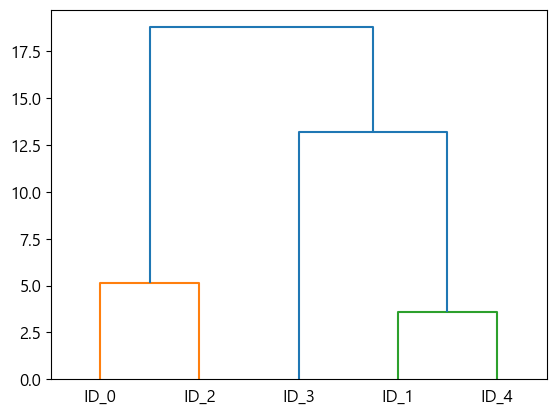

In [122]:
# 덴드로그램 출력
# 계층적 군집을 시각화 하는 도구
from scipy.cluster.hierarchy import dendrogram
row_dendr = dendrogram(row_clusters,labels=labels)
plt.show()


### Gaussian Mixture Model

In [124]:
# 샘플 데이터를 3개의 군집으로 묶기
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows wi

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [125]:
# 중심점의 좌표
print(gm.means_)

[[ 0.051  0.075]
 [-1.408  1.427]
 [ 3.399  1.059]]


In [126]:
# 예측
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2], dtype=int64)

In [127]:
# 확률
print(gm.predict_proba(X))

[[9.767e-01 6.786e-07 2.326e-02]
 [9.828e-01 6.762e-04 1.649e-02]
 [7.465e-05 9.999e-01 2.024e-06]
 ...
 [4.261e-07 2.155e-26 1.000e+00]
 [5.050e-16 1.481e-41 1.000e+00]
 [2.246e-15 8.115e-41 1.000e+00]]


In [130]:
# 생성
X_new, y_new = gm.sample(6)
print(X_new)
print(y_new)

[[-0.869 -0.328]
 [ 0.298  0.283]
 [-2.801 -0.09 ]
 [ 3.982  1.5  ]
 [ 3.817  0.531]
 [ 2.841 -0.739]]
[0 0 1 2 2 2]
